In [1]:
using Pkg;
Pkg.activate("..");
Pkg.instantiate();

  Activating project at `~/dev/uni/amo-individual-project`


This notebook implements Lagrangian Relaxation, Augmented Lagrangian Relaxation, Exchange ADMM and Consensus ADMM for basic examples.
It was created as part of the learning process and is part of the project.
It might, however, be useful to understand the concept of the algorithms.

# Lagrangian Relaxation

## Minimal example
$$
\begin{split}
&min_{x,y}  x^2 + y^2 \\
&s.t. \\
&-x - y = -4 (\mu) \\
&x \geq 0 \\
&y \geq 0 \\
\end{split}
$$

### Lagrangian

$$
\begin{split}
&\mathcal{L}(x,y,\mu) = x^2 + y^2 + \mu (-x - y + 4)\\
&s.t. \\
&x \geq 0 \\
&y \geq 0 \\
\end{split}

$$

### Decomposed
$$
min_x x^2 - \bar{\mu} x \\
s.t. \\
x \geq 0 \\
$$

$$
min_y y^2 - \bar{\mu} y \\
s.t. \\
y \geq 0 \\
$$

#

In [11]:
using JuMP
import Gurobi
using DataFrames
GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-19


Gurobi.Env(Ptr{Nothing} @0x00005608ea4de910, false, 0)

In [4]:
function solve_decomposed_problems(μ_fixed)
	dp1 = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(dp1, "OutputFlag", 0)

	@variable(dp1, x >= 0)
	@objective(dp1, Min, x*x - μ_fixed*x)
	@constraint(dp1, x >= 0)

	dp2 = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(dp2, "OutputFlag", 0)

	@variable(dp2, y >= 0)
	@objective(dp2, Min, y*y - μ_fixed*y)
	@constraint(dp2, y >= 0)

	JuMP.optimize!(dp1)
	JuMP.optimize!(dp2)

	if JuMP.termination_status(dp1) != MOI.OPTIMAL || JuMP.termination_status(dp2) != MOI.OPTIMAL
		throw("Decomposed problems are not optimal")
	end

	# c_x = -x
	# c_y = -y
	# sum c <= -4
	return Dict(
		:x => JuMP.value.(x),
		:y => JuMP.value.(y),
		:d => -JuMP.value.(x) - JuMP.value.(y) + 4
	)
end

solve_decomposed_problems (generic function with 1 method)

In [10]:
k = 0
μs = []

a = 1.2
b = 1.2

epsilon = 0.001

μ_current = 3
results = []
while true
	μs = [μs; μ_current]
	subresults = solve_decomposed_problems(μ_current)

	x = subresults[:x]
	y = subresults[:y]
	d = subresults[:d]
	d_abs = abs(d)

	L = x*x + y*y + μ_current * (x + y - 4)
	step = (1/(a+b*k))
	direction = (d / d_abs)


	μ_last = μ_current

	if d_abs != 0
		μ_current = μ_current + step * direction
	end
	k += 1

	results = [results; Dict(
		:μ => μ_current,
		:x => x,
		:y => y,
		:L => L,
		:step => step,
		:direction => direction,
	)]


	if (abs(μ_current - μ_last)/abs(μ_last)) < epsilon
		break
	end

	if k > 100
		break
	end

end

In [11]:
df = DataFrame(results)

Row,μ,y,step,L,direction,x
,Float64,Float64,Float64,Float64,Float64,Float64
1,3.83333,1.5,0.833333,1.5,1.0,1.5
2,4.25,1.91667,0.416667,6.70833,1.0,1.91667
3,3.97222,2.125,0.277778,10.0938,-1.0,2.125
4,4.18056,1.98611,0.208333,7.77894,1.0,1.98611
5,4.01389,2.09028,0.166667,9.49334,-1.0,2.09028
6,3.875,2.00694,0.138889,8.1114,-1.0,2.00694
7,3.99405,1.9375,0.119048,7.02344,1.0,1.9375
8,4.09821,1.99702,0.104167,7.95243,1.0,1.99702
9,4.00562,2.04911,0.0925926,8.80018,-1.0,2.04911


## Example with generator dispatch
$$
\begin{split}
F(P_1) = 100 + 8P_1 + 0.1 P_1^2\\
G(P_1): 230 \leq P_1 \leq 400
\end{split}
$$

$$
\begin{split}
F(P_2) = 200 + 7P_2 + 0.06 P_2^2\\
G(P_2): 100 \leq P_2 \leq 500
\end{split}
$$

$$
\begin{split}
F(P_3) = 250 + 9P_3 + 0.07 P_3^2\\
G(P_3): 100 \leq P_3 \leq 260
\end{split}
$$

$$
P_1 + P_2 + P_3 = 800
$$


### Problem

$$
\begin{split}
&\min_{P_1, P_2, P_3} \sum_{i=1}^3 F(P_i) \\
&s.t.\\
&G(P_i) \\
&P_1 + P_2 + P_3 = 800
\end{split}
$$

### Lagrangian
$$
L(P_1, P_2, P_3, \lambda) = \sum_{i=1}^3 F(P_i) + \lambda (800 - P_1 - P_2 - P_3)
$$

### Decomposed

$$
\begin{split}
&\min_{P_1} F(P_1) - \bar{\lambda} P_1 \\
&s.t.\\
&G(P_1) \\
\end{split}
$$

### Update
$$
\lambda^{k+1} = \lambda^k + \frac{1}{a+bk} \frac{800 - P_1 - P_2 - P_3}{|800 - P_1 - P_2 - P_3|}
$$

In [35]:
n_gens = 3
cost_0 = [100, 200, 250]
cost_1 = [8, 7, 9]
cost_2 = [0.1, 0.06, 0.07]

P_lower = [230, 100, 100]
P_upper = [400, 500, 260]


function solve_decomposed_problems(λ)
	Pks = []
	for i in 1:n_gens
		sp = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
		set_optimizer_attribute(sp, "OutputFlag", 0)
		@variable(sp, P_lower[i] <= P <= P_upper[i])
		@objective(sp, Min, cost_0[i] + cost_1[i] * P + cost_2[i] * P * P - λ * P)
		
		JuMP.optimize!(sp)

		if JuMP.termination_status(sp) != MOI.OPTIMAL
			throw("Decomposed problems are not optimal")
		end

		push!(Pks, JuMP.value.(P))
	end
	return Pks
end

solve_decomposed_problems (generic function with 2 methods)

In [51]:
k = 0
λs = []

a = 0.1
b = 0.1

epsilon = 0.001

λ_current = 0
results = []
while true
	λs = [λs; λ_current]
	Pks = solve_decomposed_problems(λ_current)

	d = 800 - sum(Pks)
	d_abs = abs(d)
	direction = (d / d_abs)
	step = (1/(a+b*k))

	step = (1/(a+b*k))
	direction = (d / d_abs)


	λ_last = λ_current

	if d_abs != 0
		λ_current = λ_current + step * direction
	end
	k += 1


	new_r = Dict(
		:λ => λ_current,
		:d => d,
		:step => step,
		:direction => direction,
		:k => k,
	)
	for i in 1:n_gens
		new_r[Symbol("P_$i")] = Pks[i]
	end
	results = [results; new_r]


	if (abs(λ_current - λ_last)/abs(λ_last)) < epsilon
		break
	end

	# if k > 100
	# 	break
	# end

end

In [52]:
df = DataFrame(results)

Row,d,λ,step,k,P_2,P_1,direction,P_3
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,370.0,10.0,10.0,1,100.0,230.0,1.0,100.0
2,370.0,15.0,5.0,2,100.0,230.0,1.0,100.0
3,370.0,18.3333,3.33333,3,100.0,230.0,1.0,100.0
4,370.0,20.8333,2.5,4,100.0,230.0,1.0,100.0
5,354.722,22.8333,2.0,5,115.278,230.0,1.0,100.0
6,338.056,24.5,1.66667,6,131.944,230.0,1.0,100.0
7,313.452,25.9286,1.42857,7,145.833,230.0,1.0,110.714
8,291.344,27.1786,1.25,8,157.738,230.0,1.0,120.918
9,271.998,28.2897,1.11111,9,168.155,230.0,1.0,129.847


# Augmented Lagrangian Relaxation

## Minimal example
$$
\begin{split}
&min_{x,y}  x^2 + y^2 \\
&s.t. \\
&-x - y \leq -4 (\lambda) \\
&x \geq 0 \\
&y \geq 0 \\
\end{split}
$$

### Lagrangian

$$
\begin{split}
&\mathcal{L}(x,y,\mu) = x^2 + y^2 + \lambda (-x - y + 4) + \frac{\alpha}{2}||-x-y+4||^2\\
&s.t. \\
&x \geq 0 \\
&y \geq 0 \\
\end{split}

$$

### Decomposed
$$
min_x x^2 + \bar{\lambda} (-x - \bar{y} + 4) + \frac{\alpha}{2} ||-x - \bar{y} +4||^2\\
s.t. \\
x \geq 0 \\
$$

$$
min_x y^2 + \bar{\lambda} (-\bar{x} - y + 4) + \frac{\alpha}{2} ||-\bar{x} - y +4||^2\\
s.t. \\
y \geq 0 \\
$$

**Multiplier update**
$$
\lambda^{k} = \lambda^{k-1} + \alpha (-x - y + 4)

In [101]:
α = 15
function solve_decomposed_problems(λ_fixed, y_fixed, x_fixed)
	dp1 = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(dp1, "OutputFlag", 0)

	@variable(dp1, x >= 0)
	@objective(dp1, Min, x*x - λ_fixed*x + (α/2)*(-x - y_fixed + 4)^2)
	@constraint(dp1, x >= 0)

	JuMP.optimize!(dp1)
	x_fixed = JuMP.value.(x)

	dp2 = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(dp2, "OutputFlag", 0)


	@variable(dp2, y >= 0)
	@objective(dp2, Min, y*y - λ_fixed* y + (α/2)*(-x_fixed - y + 4)^2)
	@constraint(dp2, y >= 0)

	JuMP.optimize!(dp2)

	if JuMP.termination_status(dp1) != MOI.OPTIMAL || JuMP.termination_status(dp2) != MOI.OPTIMAL
		throw("Decomposed problems are not optimal")
	end

	# c_x = -x
	# c_y = -y
	# sum c <= -4
	return Dict(
		:x => JuMP.value.(x),
		:y => JuMP.value.(y),
		:r => -JuMP.value.(x) - JuMP.value.(y) + 4
	)
end

solve_decomposed_problems (generic function with 3 methods)

In [102]:
k = 0
λs = []

epsilon = 0.001

λ_current = 3
x = 1
y = 1
results = []
while true
	λs = [λs; λ_current]
	subresults = solve_decomposed_problems(λ_current, y, x)

	x = subresults[:x]
	y_last = y
	y = subresults[:y]
	r = subresults[:r]

	L = x*x + y*y + λ_current * (-x - y + 4) + (α/2)*(-x - y + 4)^2

	λ_last = λ_current
	λ_current = λ_current + α * r
	k += 1

	sk = α * -1 * -1 *(y - y_last)
	rk = r

	results = [results; Dict(
		:λ => λ_current,
		:x => x,
		:y => y,
		:L => L,
		:sk => sk,
		:rk => rk,
	)]


	if sk < epsilon && rk < epsilon
		break
	end

	if k > 500
		break
	end

end

df = DataFrame(results)

## Example with generator dispatch

$$
\begin{split}
F(P_1) = 10P_1\\
G(P_1) = 0 \leq P_1 \leq 250\\
\end{split}
$$

$$
\begin{split}
F(P_2) = 12 P_2\\
G(P_2) = 0 \leq P_2 \leq 350\\
\end{split}
$$

$$
\begin{split}
F(P_3) = 15 P_2\\
G(P_3) = 0 \leq P_2 \leq 300\\
\end{split}
$$

$$
P_1 + P_2 + P_3 = 360
$$

### Problem

$$
\begin{split}
&\min_{P_1, P_2, P_3} \sum_{i=1}^3 F(P_i) \\
&s.t.\\
&G(P_i) \\
&P_1 + P_2 + P_3 = 360
\end{split}
$$

### Lagrangian

$$
L(P_1, P_2, P_3, \lambda) = \sum_{i=1}^3 F(P_i) + \lambda (360 - P_1 - P_2 - P_3) + \frac{\alpha}{2}||360 - P_1 - P_2 - P_3||^2
$$

### Decomposed

$$
\begin{split}
&\min_{P_1} F(P_1) - \bar{\lambda} P_1 + \frac{\alpha}{2} ||-P_1 - \bar{P_2} - \bar{P_3} + 360||^2\\
&s.t.\\
&G(P_1) \\
\end{split}
$$

### Update
$$
\lambda^{k+1} = \lambda^k + \alpha (-P_1 - P_2 - P_3 + 360)
$$

In [59]:
# correct solutions

tp = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
set_optimizer_attribute(tp, "OutputFlag", 0)

n_gens = 3
cost = [10, 12, 15]

P_lower = [0, 0, 0]
P_upper = [250, 350, 300]

@variable(tp, P_lower[i] <= P[i=1:n_gens] <= P_upper[i])
@objective(tp, Min, sum(cost[i] * P[i] for i in 1:n_gens))
@constraint(tp, sum(P[i] for i in 1:n_gens) == 360)

JuMP.optimize!(tp)

if JuMP.termination_status(tp) != MOI.OPTIMAL
	throw("Decomposed problems are not optimal")
end

Pks = JuMP.value.(P)

3-element Vector{Float64}:
 250.0
 110.0
   0.0

In [53]:
n_gens = 3
cost = [10, 12, 15]

P_lower = [0, 0, 0]
P_upper = [250, 350, 300]
α = 0.01


function solve_decomposed_problems(λ, Pks)
	Pks_next = []
	for i in 1:n_gens
		sp = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
		set_optimizer_attribute(sp, "OutputFlag", 0)
		@variable(sp, P_lower[i] <= P <= P_upper[i])
		other_Pks = [Pks[j] for j in 1:n_gens if j != i]
		@objective(sp, Min, P * cost[i] - λ * P + (α/2) * (-P - sum(other_Pks) + 360)^2)
		
		JuMP.optimize!(sp)

		if JuMP.termination_status(sp) != MOI.OPTIMAL
			throw("Decomposed problems are not optimal")
		end

		push!(Pks_next, JuMP.value.(P))
	end
	return Pks_next
end

solve_decomposed_problems (generic function with 3 methods)

In [60]:
k = 0
λs = []

λ_current = 5
results = []
Pks = [10, 200, 150]
while true
	λs = [λs; λ_current]
	Pks = solve_decomposed_problems(λ_current, Pks)

	λ_last = λ_current

	λ_current = λ_current + α * (360 - sum(Pks))
	k += 1


	new_r = Dict(
		:λ => λ_current,
		:k => k,
	)
	for i in 1:n_gens
		new_r[Symbol("P_$i")] = Pks[i]
	end
	results = [results; new_r]


	if k > 100
		break
	end

end

In [61]:
results = DataFrame(results)

Row,λ,k,P_2,P_1,P_3
,Float64,Int64,Float64,Float64,Float64
1,8.6,1,0.0,0.0,0.0
2,9.8,2,20.0,220.0,0.0
3,10.9,3,0.0,250.0,0.0
4,12.0,4,4.44089e-14,250.0,0.0
5,12.0,5,110.0,250.0,0.0
6,12.0,6,110.0,250.0,0.0
7,12.0,7,110.0,250.0,0.0
8,12.0,8,110.0,250.0,0.0
9,12.0,9,110.0,250.0,0.0


# Exchange ADMM

In [62]:
n_gens = 3
cost = [10, 12, 15]

P_lower = [0, 0, 0]
P_upper = [250, 350, 300]
α = 0.01


function solve_decomposed_problems(λ, Pks)
	Pks_next = []
	for i in 1:n_gens
		# we don't pass all the Pks to the agent, but only the mean and his own
		# last value
		last_Pk = Pks[i]
		mean_Pk = sum(Pks)/n_gens

		sp = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
		set_optimizer_attribute(sp, "OutputFlag", 0)
		@variable(sp, P_lower[i] <= P <= P_upper[i])
		@objective(sp, Min, P * cost[i] - λ * P + (α/2) * (-P - sum(3*mean_Pk - last_Pk) + 360)^2)
		
		JuMP.optimize!(sp)

		if JuMP.termination_status(sp) != MOI.OPTIMAL
			throw("Decomposed problems are not optimal")
		end

		push!(Pks_next, JuMP.value.(P))
	end
	return Pks_next
end

solve_decomposed_problems (generic function with 3 methods)

In [63]:
# exactly the same as above
k = 0
λs = []

λ_current = 5
results = []
Pks = [10, 200, 150]
while true
	λs = [λs; λ_current]
	Pks = solve_decomposed_problems(λ_current, Pks)

	λ_last = λ_current

	λ_current = λ_current + α * (360 - sum(Pks))
	k += 1


	new_r = Dict(
		:λ => λ_current,
		:k => k,
	)
	for i in 1:n_gens
		new_r[Symbol("P_$i")] = Pks[i]
	end
	results = [results; new_r]


	if k > 100
		break
	end

end

In [64]:
df = DataFrame(results)

Row,λ,k,P_2,P_1,P_3
,Float64,Int64,Float64,Float64,Float64
1,8.6,1,0.0,0.0,0.0
2,9.8,2,20.0,220.0,0.0
3,10.9,3,0.0,250.0,0.0
4,12.0,4,4.44089e-14,250.0,0.0
5,12.0,5,110.0,250.0,0.0
6,12.0,6,110.0,250.0,0.0
7,12.0,7,110.0,250.0,0.0
8,12.0,8,110.0,250.0,0.0
9,12.0,9,110.0,250.0,0.0


# Consensus ADMM
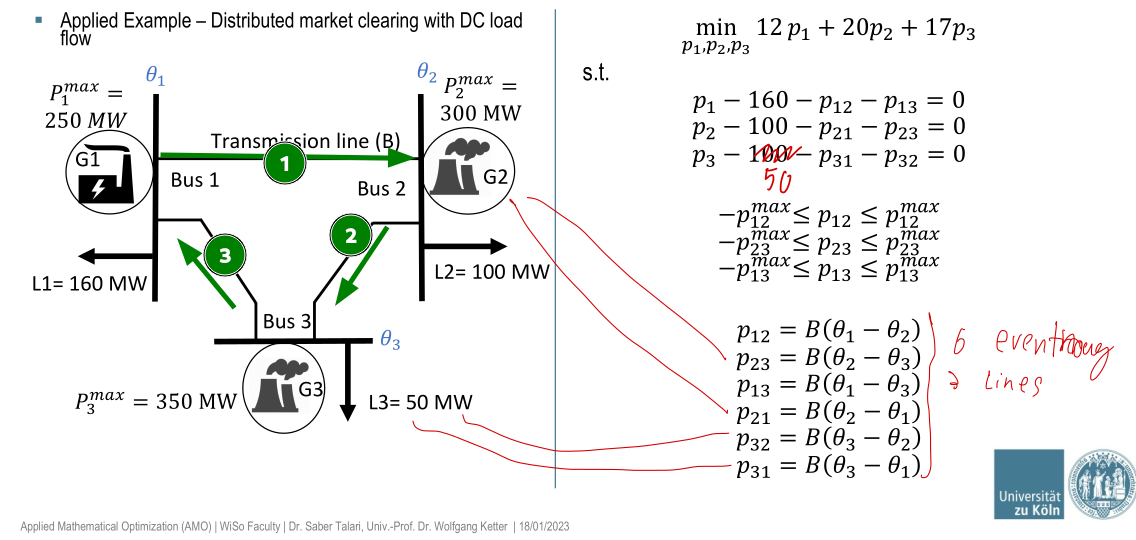


lines im uhrzeigersinn

In [105]:
P_min = [0, 0, 0]
P_max = [250, 300, 350]

load = [160, 100, 50]

l_from = [0, 1, 2]
l_to = [1, 2, 0]
# l_cap = [100, 100, 100]

n_gens = 3

3

In [17]:
busses = Dict(
	:B1 => Dict(
		:id => :B1,
		:cost => 12,
		:P_min => 0,
		:P_max => 250,
		:load => 160,
		:incoming => [:L3],
		:outgoing => [:L1],
		:is_reference => true,
	),
	:B2 => Dict(
		:id => :B2,
		:cost => 20,
		:P_min => 0,
		:P_max => 300,
		:load => 100,
		:incoming => [:L1],
		:outgoing => [:L2],
	),
	:B3 => Dict(
		:id => :B3,
		:cost => 17,
		:P_min => 0,
		:P_max => 350,
		:load => 50,
		:incoming => [:L2],
		:outgoing => [:L3],
	),
)

lines = Dict(
	:L1 => Dict(
		:id => :L1,
		:from => :B1,
		:to => :B2,
		:capacity => 100,
	),
	:L2 => Dict(
		:id => :L2,
		:from => :B2,
		:to => :B3,
		:capacity => 100,
	),
	:L3 => Dict(
		:id => :L3,
		:from => :B3,
		:to => :B1,
		:capacity => 100,
	),
)

Dict{Symbol, Dict{Symbol, Any}} with 3 entries:
  :L2 => Dict(:id=>:L2, :from=>:B2, :to=>:B3, :capacity=>100)
  :L1 => Dict(:id=>:L1, :from=>:B1, :to=>:B2, :capacity=>100)
  :L3 => Dict(:id=>:L3, :from=>:B3, :to=>:B1, :capacity=>100)

In [151]:
ρ = 0.1

function solve_bus_problem(bus, δs, λ_δs)
    m = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(m, "OutputFlag", 0)

    @variable(m, bus[:P_min] <= P <= bus[:P_max])

    @variable(m, δ[line_id in vcat(bus[:incoming], bus[:outgoing])])

    @constraint(m,
        bus[:load] ==
        P +
        sum(δ[line_id] for line_id in bus[:incoming]) -
        sum(δ[line_id] for line_id in bus[:outgoing])
    )

    @objective(m, Min, bus[:cost] * P + 
		 sum(λ_δs[line_id] * δ[line_id] for line_id in vcat(bus[:incoming], bus[:outgoing])) +
		  ρ / 2 * sum((δ[line_id] - δs[line_id])^2 for line_id in vcat(bus[:incoming], bus[:outgoing])))

    JuMP.optimize!(m)

    δ_results = Dict()
    for line_id in vcat(bus[:incoming], bus[:outgoing])
        δ_results[line_id] = JuMP.value.(δ[line_id])
    end
    return Dict(
        :P => JuMP.value.(P),
        :δ => δ_results,
    )
end


function solve_line_problem(line, δs, λ_δs)
    m = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attribute(m, "OutputFlag", 0)

    @variable(m, -line[:capacity] <= δ <= line[:capacity])

    @objective(m, Min, λ_δs[line[:id]] * δ + ρ / 2 * (δ - δs[line[:id]])^2)

    JuMP.optimize!(m)
    return Dict(
        :δ => Dict(line[:id] => JuMP.value.(δ))
    )
end

solve_line_problem (generic function with 1 method)

In [152]:
δs = Dict()
for line_id in keys(lines)
	δs[line_id] = 0
end
λ_δs = Dict()
for line_id in keys(lines)
	λ_δs[line_id] = Dict(line_id => 0)
end
for bus_id in keys(busses)
	λ_δs[bus_id] = Dict()
	for line_id in vcat(busses[bus_id][:incoming], busses[bus_id][:outgoing])
		λ_δs[bus_id][line_id] = 0
	end
end

λ_δs

Dict{Any, Any} with 6 entries:
  :B3 => Dict{Any, Any}(:L2=>0, :L3=>0)
  :L2 => Dict(:L2=>0)
  :B1 => Dict{Any, Any}(:L3=>0, :L1=>0)
  :L1 => Dict(:L1=>0)
  :L3 => Dict(:L3=>0)
  :B2 => Dict{Any, Any}(:L2=>0, :L1=>0)

In [153]:
ϵ = 0.0001
Ps = Dict()
for i in 1:100
	results = Dict()
	Ps = Dict()
	for (bus_id, bus) in busses
		bus_result = solve_bus_problem(bus, δs, λ_δs[bus_id])
		results[bus_id] = bus_result[:δ]
		Ps[bus_id] = bus_result[:P]
	end

	for (line_id, line) in lines
		results[line_id] = solve_line_problem(line, δs, λ_δs[line_id])[:δ]
	end

	pooled_results = Dict()
	for result in values(results)
		for (key, value) in result
			if !haskey(pooled_results, key)
				pooled_results[key] = []
			end
			push!(pooled_results[key], value)
		end
	end

	agg_results = Dict()
	for (key, value) in pooled_results
		agg_results[key] = sum(value) / length(value)
	end

	residuals = []
	diffs_λ_δs = []
	new_λ_δs = Dict()
	for line_id in keys(lines)
		local_results = results[line_id]
		residual = local_results[line_id] - agg_results[line_id]

		push!(residuals, residual)
		new_λ_δs[line_id] = Dict(line_id => λ_δs[line_id][line_id] + ρ * residual)
		push!(diffs_λ_δs, new_λ_δs[line_id][line_id] - λ_δs[line_id][line_id])
	end

	for (bus_id, bus) in busses
		local_results = results[bus_id]
		new_λ_δ = Dict()
		for line_id in vcat(bus[:incoming], bus[:outgoing])
			residual = local_results[line_id] - agg_results[line_id]

			push!(residuals, residual)
			new_λ_δ[line_id] = λ_δs[bus_id][line_id] + ρ * residual
			push!(diffs_λ_δs, new_λ_δ[line_id] - λ_δs[bus_id][line_id])
		end
		new_λ_δs[bus_id] = new_λ_δ
	end

	r = sum((residuals).^2)
	s = sum((diffs_λ_δs).^2) * ρ^2 * length(diffs_λ_δs)

	λ_δs = new_λ_δs
	δs = agg_results

	primal_convergence = r < ϵ
	dual_convergence = s < ϵ

	if primal_convergence && dual_convergence
		
		break
	end

	# print convergence with consistent spacing
	print(lpad(i, 3, " "))
	print(" ")
	print(lpad(r, 10, " "))
	print(" ")
	println(lpad(s, 10, " "))
end

  1 17533.33333283003 15.779999999547028
  2 13787.037035898597 12.408333332308741
  3 10110.596707457691 9.099537036711926
  4 3822.9881118784897 3.440689300690641
  5 271.10196513704096 0.2439917686233369
  6 73.93721702311771 0.06654349532080603
  7 800.7960366332934 0.7207164329699648
  8 644.6998447891042 0.5802298603101936
  9 163.1222439255187 0.14681001953296682
 10 65.04749637942011 0.058542746741478
 11 110.85612412735543 0.09977051171462008
 12 80.62220045511575 0.07255998040960428
 13 25.051740520439722 0.02254656646839582
 14 2.7951330850526586 0.0025156197765474012
 15 3.7234454158434165 0.0033511008742590867
 16 9.462805374724516 0.008516524837252097
 17 14.626036496741596 0.013163432847067495
 18 16.546562021574257 0.01489190581941687
 19 13.46450972312731 0.012118058750814557
 20 7.349473065641155 0.006614525759077033
 21 2.0888276847315703 0.0018799449162583966
 22 0.025047914409122813 2.2543122968210393e-5
 23 0.8868267460372984 0.0007981440714335551
 24 2.8623544634

 34 0.8496248263408425 0.0007646623437067574
 35 0.4483332210363946 0.0004034998989327615
 36 0.12098949593259382 0.0001088905463393385
 37 0.00047313173887333514 4.25818564985945e-7
 38 0.06432550551292586 5.789295496162618e-5
 39 0.1943273291626029 0.00017489459624633595
 40 0.2739008938140467 0.000246510804432639
 41 0.2549282715237131 0.00022943544437134655
 42 0.16433099028436388 0.00014789789125591664
 43 0.06496169609651226 5.8465526486866694e-5
 44 0.007565247538922058 6.808722785029652e-6
 45 0.004547151083001708 4.092435974700671e-6
 46 0.034176758620821444 3.075908275873844e-5
 47 0.0634647745035272 5.711829705317037e-5
 48 0.07065617254644486 6.359055529179327e-5
 49 0.0543287789503644 4.889590105533315e-5
 50 0.027877424284948167 2.5089681856449652e-5
 51 0.007062347735428253 6.356112961884742e-6


In [150]:
δs

Dict{Any, Any} with 3 entries:
  :L2 => -9.0
  :L3 => -7.0
  :L1 => 16.0

In [138]:
Ps

Dict{Any, Any} with 3 entries:
  :B3 => 60.002
  :B1 => 250.0
  :B2 => 5.57712e-10

In [121]:
# test results with simple model
m = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
set_optimizer_attribute(m, "OutputFlag", 0)


@variable(m, busses[bus_id][:P_min] <= P[bus_id in keys(busses)] <= busses[bus_id][:P_max])

@variable(m, -lines[line_id][:capacity] <= δ[line_id in keys(lines)] <= lines[line_id][:capacity])

for (bus_id, bus) in busses
	@constraint(m,
		bus[:load] ==
		P[bus_id] +
		sum(δ[line_id] for line_id in bus[:incoming]) -
		sum(δ[line_id] for line_id in bus[:outgoing])
	)
end

@objective(m, Min, sum(bus[:cost] * P[bus_id] for (bus_id, bus) in busses))

JuMP.optimize!(m)

Ps_test = JuMP.value.(P)
δs_test = Dict()
for line_id in keys(lines)
	δs_test[line_id] = JuMP.value.(δ[line_id])
end

In [122]:
Ps_test

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, [:B3, :B1, :B2]
And data, a 3-element Vector{Float64}:
  60.0
 250.0
   0.0

In [123]:
δs_test

Dict{Any, Any} with 3 entries:
  :L2 => -100.0
  :L1 => 0.0
  :L3 => -90.0